# Datasets Analysis for Modeling Semantic Plausibility: pep-3k

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk import word_tokenize, pos_tag,FreqDist
import seaborn as sns
import spacy
from gensim.models import KeyedVectors
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# download punkt and averaged_perceptron_tagger
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

## Load and Combine Files

In [98]:
def combine_datasets(file_paths):
    
    dataframes = []
    
    for file_path in file_paths:
        data = pd.read_csv(file_path)
        dataframes.append(data)
    
    combined_data = pd.concat(dataframes, ignore_index=True)
    
    return combined_data

file_paths = ['/mount/studenten/semantic-plausibility/datasets/pep-3k/train-dev-test-split/dev.csv', 
              '/mount/studenten/semantic-plausibility/datasets/pep-3k/train-dev-test-split/test.csv', 
              '/mount/studenten/semantic-plausibility/datasets/pep-3k/train-dev-test-split/train.csv']

dataset = combine_datasets(file_paths)
print(dataset)

      label                  text
0         0   elephant vomit boat
1         1   tape attach sticker
2         1        knife dig bike
3         1        girl cut grape
4         1   policeman halt ball
...     ...                   ...
3057      0        wool clip dust
3058      1         rope hook pan
3059      0      bag contain tree
3060      1     gorilla bury leaf
3061      1  sidewalk curb wheels

[3062 rows x 2 columns]


##  Analyze Dataset Characteristics
### Aspect 1: Word Count and Frequrncy Analysis
- This dataset covers a relatively small pool of words (584 unique words). 
- These words exhibit a high level of repetition (584/9186), highlighting a significant frequency among certain words, with some repeting over a hundred times.

Total number of words in the dataset: 9186
Total number of unique words in the dataset: 584


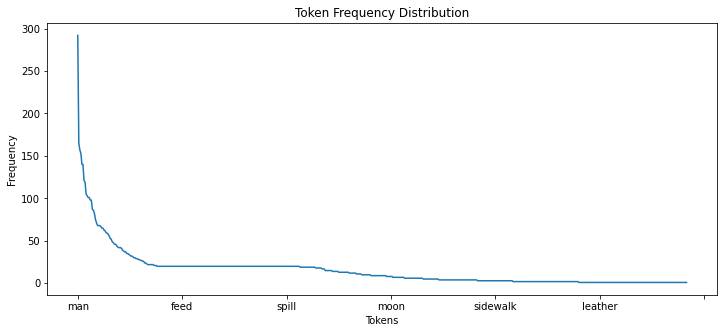

Top 10 frequent words and their frequencies:
man         292
air         165
dog         157
water       153
girl        140
elephant    140
hand        121
cat         119
house       105
child       103
dtype: int64


man       292
air       165
dog       157
water     153
girl      140
         ... 
school      1
worker      1
jaw         1
onions      1
jeans       1
Length: 584, dtype: int64

In [83]:
def total_words(dataset):
    
    # Combine text data into a single string
    all_text = ' '.join(dataset['text']).lower()

    tokens = word_tokenize(all_text)
    total_words_count = len(tokens)

    print(f"Total number of words in the dataset: {total_words_count}")

    return total_words_count

def total_unique_words(dataset):
    
    all_text = ' '.join(dataset['text']).lower()

    tokens = word_tokenize(all_text)
    unique_words = set(tokens)
    total_unique_words = len(unique_words)

    print(f"Total number of unique words in the dataset: {total_unique_words}")

    return total_unique_words

def token_frequency(dataset):
    
    all_text = ' '.join(dataset['text']).lower().split()
    token_frequency = pd.Series(all_text).value_counts()

    #Show the word frequency in line
    plt.figure(figsize=(12, 5))
    token_frequency.plot()
    plt.xlabel('Tokens')
    plt.ylabel('Frequency')
    plt.title('Token Frequency Distribution')
    plt.show()
    
    # Get the top 10 frequency words and their frequencies
    top_10_words = token_frequency.head(10)
    print("Top 10 frequent words and their frequencies:")
    print(top_10_words)

    return token_frequency

total_words(dataset)
total_unique_words(dataset)
token_frequency(dataset)

### Aspect 2: Abstractness and Concreteness  Analysis 
   - Use `concrete_13428_2013_403_MOESM1_ESM.xlsx` to get concretreness score
   - Subjects and objects exhibited significantly high concreteness scores.
   - Despite lable1 (plausible) scoring higher than lable0 (implausible), the difference between the two is nearly negligible.

************Concreteness Analysis for Subject************
label                                    0      1
Subject_concreteness_score_category              
2-3                                    NaN   0.03
3-4                                   0.59   0.29
4-5                                  49.51  49.58


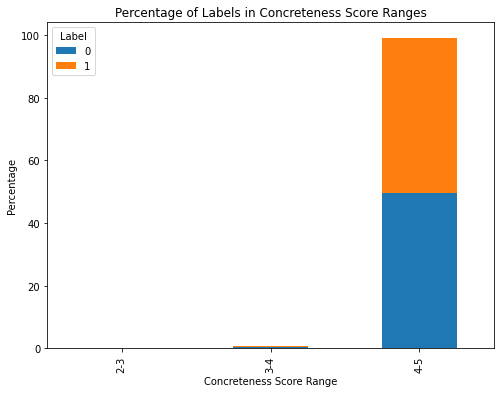

************Concreteness Analysis for Object************
label                                   0      1
Object_concreteness_score_category              
3-4                                  1.21   0.42
4-5                                 48.89  49.48


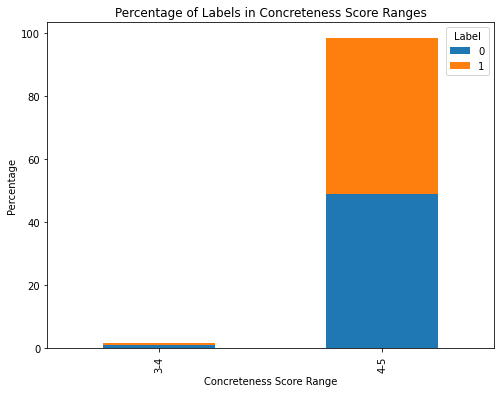

In [101]:
def concreteness_analysis(dataset, concreteness_scores_path):

    # Load the Concreteness Score Database
    concreteness_scores = pd.read_excel(concreteness_scores_path)
    concreteness_scores = concreteness_scores[['Word', 'Conc.M']]

    def get_concreteness_category(score):
        if score >= 0.0 and score < 1.0:
            return '0-1'
        elif score >= 1.0 and score < 2.0:
            return '1-2'
        elif score >= 2.0 and score < 3.0:
            return '2-3'
        elif score >= 3.0 and score < 4.0:
            return '3-4'
        else:
            return '4-5'

    def get_concreteness_score(word):
        word = word.lower()
        score = concreteness_scores[concreteness_scores['Word'] == word]['Conc.M'].values
        return score[0] if len(score) > 0 else None
    
    
    def analyze_words(dataset, word_position, syntax_name):
        new_dataset = dataset.copy() 
        words = new_dataset['text'].str.split().str[word_position]
        concreteness_scores = []

        for word in words:
            score = get_concreteness_score(word)
            concreteness_scores.append(score)

        new_dataset[f'{syntax_name}_concreteness_score'] = concreteness_scores
        return new_dataset

    def analyze_concreteness_percentage(dataset, word_position, syntax_name):
        col_name = f'{syntax_name}_concreteness_score'
        temp_dataset = dataset.copy()  

        temp_dataset[f'{col_name}_category'] = temp_dataset[col_name].apply(get_concreteness_category)
        label_concreteness_percentage = temp_dataset.groupby([f'{col_name}_category', 'label']).size().unstack()
        total_words = dataset['text'].str.split().str[word_position].count()  
        label_concreteness_percentage = label_concreteness_percentage.div(total_words, axis=0) * 100
        label_concreteness_percentage = label_concreteness_percentage.round(2)
        return label_concreteness_percentage

    def visualize_label_percentage(label_counts):
        label_counts.plot(kind='bar', stacked=True, figsize=(8, 6))
        plt.title('Percentage of Labels in Concreteness Score Ranges')
        plt.xlabel('Concreteness Score Range')
        plt.ylabel('Percentage')
        plt.legend(title='Label')
        plt.show()
        
    print("************Concreteness Analysis for Subject************")
    dataset_with_scores = analyze_words(dataset, 0, 'Subject')
    concreteness_percentage = analyze_concreteness_percentage(dataset_with_scores, 0, 'Subject')
    print(concreteness_percentage)
    visualize_label_percentage(concreteness_percentage)
    
    print("************Concreteness Analysis for Object************")
    dataset_with_scores = analyze_words(dataset, 2, 'Object')
    concreteness_percentage = analyze_concreteness_percentage(dataset_with_scores, 2, 'Object')
    print(concreteness_percentage)
    visualize_label_percentage(concreteness_percentage)


concreteness_scores_path = '/mount/studenten/arbeitsdaten-studenten1/semantic-plausibility/soaring-falcons/concrete_13428_2013_403_MOESM1_ESM.xlsx'
concreteness_analysis(dataset, concreteness_scores_path)

### Aspect 3: Part-of-Speech Tag Distribution Analysis
- Nouns constitute the highest percentage, accounting for 70.2%.
- Following that, verbs make up 16.2% of the words.
- Proper nouns (often names or specific entities) represent 11.5%.
- Adjectives, although a smaller portion at 2.1%, might contain some mislabeling or ambiguity in their tagging.
- Auxiliary verbs and interjections are minimal, making up 0.0%.
- There is no evidence supporting a preference between 'plausible' and 'implausible' for ambiguous adjectives.

Top 10 frequent tags and their percentages:
  POS_Tag  Frequency  Percentage
0    NOUN       6447        70.2
1    VERB       1489        16.2
2   PROPN       1052        11.5
3     ADJ        193         2.1
4     AUX          3         0.0
5    INTJ          2         0.0


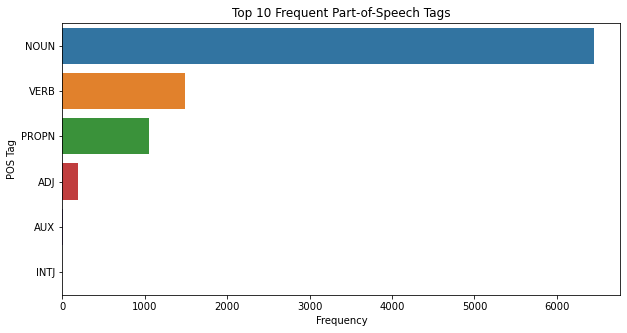

In [85]:
# Load the SpaCy model
# nlp = spacy.load('en_core_web_sm')
# nlp = spacy.load('en_core_web_md') 

nlp = spacy.load('en_core_web_lg') # with higher accuracy

def pos_tag_distribution(dataset):
    
    all_text = ' '.join(dataset['text']).lower()
    
    doc = nlp(all_text)
    pos_tags = [token.pos_ for token in doc]
    
    tag_freq = pd.Series(pos_tags).value_counts().reset_index()
    tag_freq.columns = ['POS_Tag', 'Frequency']
    
    total_tags = tag_freq['Frequency'].sum()
    tag_freq['Percentage'] = (tag_freq['Frequency'] / total_tags) * 100
    tag_freq['Percentage'] = tag_freq['Percentage'].round(1)
    
    top_10_tags = tag_freq.head(10)
    print("Top 10 frequent tags and their percentages:")
    print(top_10_tags)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Frequency', y='POS_Tag', data=top_10_tags)
    plt.title('Top 10 Frequent Part-of-Speech Tags')
    plt.xlabel('Frequency')
    plt.ylabel('POS Tag')
    plt.show()

pos_tag_distribution(dataset)

        Adj                Text  Label
0      warm     fire warm vapor      1
1       wet       water wet oil      0
2      cool  spatula cool table      0
3     close  dentist close door      0
4      warm   stove warm rabbit      1
..      ...                 ...    ...
177  remote     man feed remote      0
178    open  infant open closet      1
179  remote      man hit remote      1
180   close  water close bottle      0
181    warm       ice warm bush      0

[182 rows x 3 columns]
Counts of ADJ in 0 and 1 labels:
0    92
1    90
Name: Label, dtype: int64
Percentages of ADJ in 0 and 1 labels:
0    50.55
1    49.45
Name: Label, dtype: float64


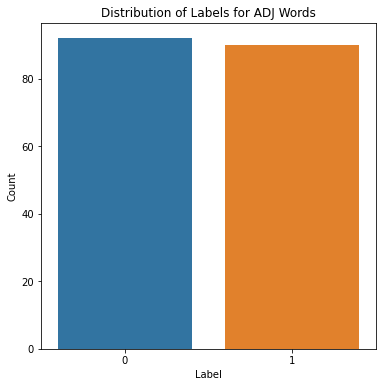

In [86]:
def show_adj_words(dataset):
    adj_words = []
    text_associated = []
    label_associated = []
    
    for index, row in dataset.iterrows():
        text = row['text']
        label = row['label']
        doc = nlp(text)
        for token in doc:
            if token.pos_ == 'ADJ':
                adj_words.append(token.text)
                text_associated.append(text)
                label_associated.append(label)
    
    adj_text = pd.DataFrame({'Adj': adj_words, 'Text': text_associated, 'Label': label_associated})
    return adj_text

def plot_adj_label_distribution(adj_text):
    adj_label_counts = adj_text['Label'].value_counts()
    adj_label_percentages = (adj_label_counts / adj_label_counts.sum()) * 100
    adj_label_percentages = adj_label_percentages.round(2)
    
    print("Counts of ADJ in 0 and 1 labels:")
    print(adj_label_counts)
    
    print("Percentages of ADJ in 0 and 1 labels:")
    print(adj_label_percentages)
    
    plt.figure(figsize=(6, 6))
    sns.countplot(x='Label', data=adj_text)
    plt.title('Distribution of Labels for ADJ Words')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()
    
    return adj_label_percentages

print(show_adj_words(dataset))
adj_label_percentages = plot_adj_label_distribution(show_adj_words(dataset))

### Aspect 4: Similarity Analysis
- Cosine Similarity Values
 - 1 indicates perfect similarity.
 - 0 indicates no similarity.
 - 1 indicates perfect dissimilarity or opposite directions.

#### Plausible Words and Implausible Words Similarity Analysis in Subject, Verb, Object Category. 
- The words show slightly similarity between plausible and implausible in each category.
 - Mean similarity score of plausible/implausible words in Subject: 0.19
 - Mean similarity score of plausible/implausible words in Verb: 0.17
 - Mean similarity score of plausible/implausible words in Object: 0.15

In [102]:
def get_word_vectors(word_set):
        
    word_vectors = []
    for word in word_set:
        try:
            word_vectors.append(word2vec_model[word])
        except KeyError:
            pass
            
    return np.array(word_vectors)

word2vec_path = '/mount/studenten/arbeitsdaten-studenten1/semantic-plausibility/soaring-falcons/word2vec-google-news-300.gz'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [103]:
sub_0 = dataset[dataset['label'] == 0]['text'].apply(lambda x: x.split()[0])
verb_0 = dataset[dataset['label'] == 0]['text'].apply(lambda x: x.split()[1])
obj_0 = dataset[dataset['label'] == 0]['text'].apply(lambda x: x.split()[2])

sub_1 = dataset[dataset['label'] == 1]['text'].apply(lambda x: x.split()[0])
verb_1 = dataset[dataset['label'] == 1]['text'].apply(lambda x: x.split()[1])
obj_1 = dataset[dataset['label'] == 1]['text'].apply(lambda x: x.split()[2])

    
# Get word vectors for each set
sub_0_vectors = get_word_vectors(sub_0)
verb_0_vectors = get_word_vectors(verb_0)
obj_0_vectors = get_word_vectors(obj_0)

sub_1_vectors = get_word_vectors(sub_1)
verb_1_vectors = get_word_vectors(verb_1)
obj_1_vectors = get_word_vectors(obj_1)

In [104]:
# Calculate cosine similarity matrix within each set
def calculate_similarity_matrix(vectors_1, vectors_2):
    similarity_matrix = cosine_similarity(vectors_1, vectors_2)
    return similarity_matrix

def calculate_similarity(word_set_0, word_set_1):
    word_vectors_0 = get_word_vectors(word_set_0)
    word_vectors_1 = get_word_vectors(word_set_1)

    similarity_matrix = calculate_similarity_matrix(word_vectors_0, word_vectors_1)
    return similarity_matrix

similarity_matrix_sub = calculate_similarity_matrix(sub_0_vectors, sub_1_vectors)
similarity_matrix_verb = calculate_similarity_matrix(verb_0_vectors, verb_1_vectors)
similarity_matrix_obj = calculate_similarity_matrix(obj_0_vectors, obj_1_vectors)

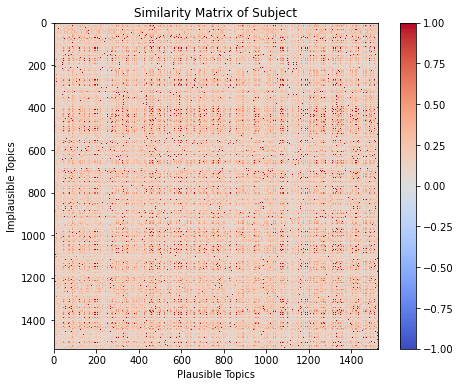

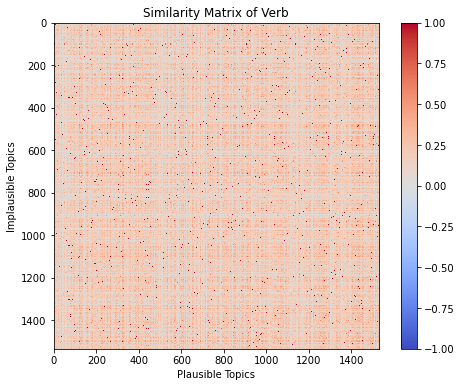

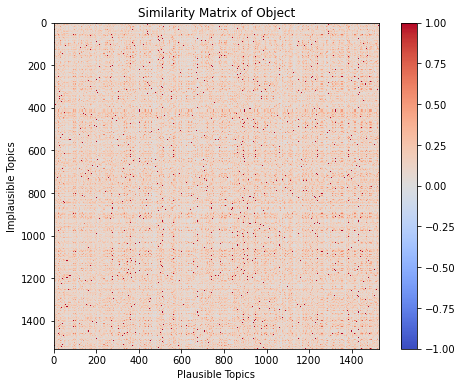

In [105]:
# Show it in picture
def visualize_similarity_matrix(similarity_matrix, matrix_name):
    plt.figure(figsize=(8, 6))
    plt.imshow(similarity_matrix, cmap='coolwarm', vmin=-1, vmax=1, interpolation='nearest')
    plt.title(f'Similarity Matrix of {matrix_name}')
    plt.colorbar()
    plt.xlabel('Plausible Topics')
    plt.ylabel('Implausible Topics')
    plt.show()
    
visualize_similarity_matrix(similarity_matrix_sub, "Subject")
visualize_similarity_matrix(similarity_matrix_verb, "Verb")
visualize_similarity_matrix(similarity_matrix_obj, "Object")

In [106]:
# Calculate average similarity scores for each matrix
avg_similarity_sub = np.mean(similarity_matrix_sub).round(2)
print("Mean similarity score of plausible/implausible words in Subject:", avg_similarity_sub)
avg_similarity_verb = np.mean(similarity_matrix_verb).round(2)
print("Mean similarity score of plausible/implausible words in Verb:", avg_similarity_verb)
avg_similarity_obj = np.mean(similarity_matrix_obj).round(2)
print("Mean similarity score of plausible/implausible words in Object:", avg_similarity_obj)
    
# Calculate highest and lowest similarity scores in the matrices
max_similarity_sub = np.max(similarity_matrix_sub).round(2)
min_similarity_sub = np.min(similarity_matrix_sub).round(2)
max_similarity_verb = np.max(similarity_matrix_verb).round(2)
min_similarity_verb = np.min(similarity_matrix_verb).round(2)
max_similarity_obj = np.max(similarity_matrix_obj).round(2)
min_similarity_obj = np.min(similarity_matrix_obj).round(2)
    
print('\n')
print("Highest similarity score in Subject:", max_similarity_sub)
print("Lowest similarity score in Subject:", min_similarity_sub)
print('\n')
print("Highest similarity score in Verb:", max_similarity_verb)
print("Lowest similarity score in Verb:", min_similarity_verb)
print('\n')
print("Highest similarity score in Object:", max_similarity_obj)
print("Lowest similarity score in Object:", min_similarity_obj)

Mean similarity score of plausible/implausible words in Subject: 0.19
Mean similarity score of plausible/implausible words in Verb: 0.17
Mean similarity score of plausible/implausible words in Object: 0.15


Highest similarity score in Subject: 1.0
Lowest similarity score in Subject: -0.12


Highest similarity score in Verb: 1.0
Lowest similarity score in Verb: -0.1


Highest similarity score in Object: 1.0
Lowest similarity score in Object: -0.12


#### Plausible Words and Implausible Words Similarity Analysis in Topic Category. 
- Topic between plausible and implausible shows slightly similarity(Average Similarity Score is 0.12).
- Some of the topic can be perfect similarity( Highest Similarity Score is 1.0)

In [107]:
def generate_topics(dataset):
    
    data_copy = dataset.copy()
    data_copy['topic'] = ""
    
    text_data = data_copy['text']
    vectorizer = CountVectorizer(stop_words='english')
    
    for idx, text in enumerate(text_data):
        
        X = vectorizer.fit_transform([text])
        
        # Use LatentDirichletAllocation to generate topics
        lda = LatentDirichletAllocation(n_components=3, random_state=42)
        lda.fit(X)
        
        # Get the a topic word for each text
        feature_names = vectorizer.get_feature_names_out()
        top_word = feature_names[lda.components_[0].argsort()[-1]]  
        
        # Store topic word in "topic" column
        data_copy.at[idx, 'topic'] = top_word
    
    return data_copy

dataset_with_topic = generate_topics(dataset)
print(dataset_with_topic)

      label                  text   topic
0         0   elephant vomit boat    boat
1         1   tape attach sticker  attach
2         1        knife dig bike    bike
3         1        girl cut grape     cut
4         1   policeman halt ball    ball
...     ...                   ...     ...
3057      0        wool clip dust    clip
3058      1         rope hook pan    hook
3059      0      bag contain tree     bag
3060      1     gorilla bury leaf    bury
3061      1  sidewalk curb wheels    curb

[3062 rows x 3 columns]


In [108]:
def topic_set(dataset_with_topic):
    plausible_topic = set()
    implausible_topic = set()

    for index, row in dataset_with_topic.iterrows():
        if row['label'] == 1:
            plausible_topic.add(row['topic'])
        elif row['label'] == 0:
            implausible_topic.add(row['topic'])

    return plausible_topic, implausible_topic

plausible_set, implausible_set = topic_set(dataset_with_topic)

In [109]:
plausible_vectors = get_word_vectors(plausible_set)
implausible_vectors = get_word_vectors(implausible_set)

In [110]:
# Calculate cosine similarity matrix within each set
similarity_matrix_topic = calculate_similarity_matrix(implausible_vectors, plausible_vectors)

avg_similarity_sub = np.mean(similarity_matrix).round(2)
print("Average Similarity Score:", average_similarity)

highest_similarity = np.max(similarity_matrix).round(2)
print("Highest Similarity Score:", highest_similarity)

lowest_similarity = np.min(similarity_matrix).round(2)
print("Lowest Similarity Score:", lowest_similarity)

Average Similarity Score: 0.12
Highest Similarity Score: 1.0
Lowest Similarity Score: -0.15


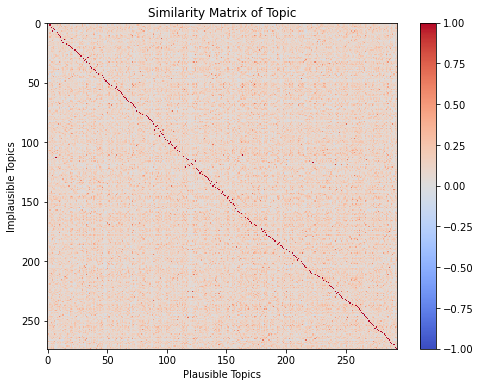

In [111]:
# Show it in picture with color map
visualize_similarity_matrix(similarity_matrix_topic, "Topic")

### Aspect 5: Word Overlap Across Train, Dev, and Test Datasets Analysis
- A small percentage of new words is observed in the dev dataset (1.88%) and test dataset (1.71%).

Word Overlap Across Train, Dev, and Test Datasets:
Overlap words in three datasets: 233 (39.90%)
Overlap words in two datasets: 156 (26.71%)
Words only in Train: 174 (29.79%)
Words only in Dev: 11 (1.88%)
Words only in Test: 10 (1.71%)


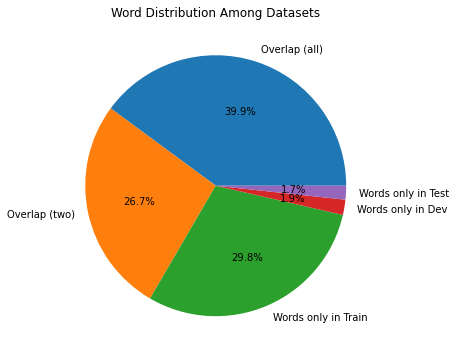

In [97]:
def word_overlap(train_data, dev_data, test_data):
    
    train_data = pd.read_csv(train_data)
    dev_data = pd.read_csv(dev_data)
    test_data = pd.read_csv(test_data)

    # Get sets of words from each dataset
    train_words = set([word.lower() for text in train_data['text'] for word in text.split()])
    dev_words = set([word.lower() for text in dev_data['text'] for word in text.split()])
    test_words = set([word.lower() for text in test_data['text'] for word in text.split()])

    # Calculate overlapping words
    overlap_in_three = train_words.intersection(dev_words, test_words)
    overlap_in_two = (train_words.intersection(dev_words) | train_words.intersection(test_words) | dev_words.intersection(test_words)) - overlap_in_three

    # Calculate unique words in each dataset
    train_unique = train_words - (overlap_in_three | overlap_in_two)
    dev_unique = dev_words - (overlap_in_three | overlap_in_two)
    test_unique = test_words - (overlap_in_three | overlap_in_two)

    # Calculate counts and percentages
    total_words = len(train_unique) + len(dev_unique) + len(test_unique) + len(overlap_in_three) + len(overlap_in_two)
    overlap_in_three_count = len(overlap_in_three)
    overlap_in_two_count = len(overlap_in_two)
    train_unique_count = len(train_unique)
    dev_unique_count = len(dev_unique)
    test_unique_count = len(test_unique)

    # Calculate percentages
    overlap_in_three_percentage = (overlap_in_three_count / total_words) * 100
    overlap_in_two_percentage = (overlap_in_two_count / total_words) * 100
    train_unique_percentage = (train_unique_count / total_words) * 100
    dev_unique_percentage = (dev_unique_count / total_words) * 100
    test_unique_percentage = (test_unique_count / total_words) * 100

    # Store statistics
    labels = ['Overlap (all)', 'Overlap (two)', 'Words only in Train', 'Words only in Dev', 'Words only in Test']
    sizes = [ overlap_in_three_count, overlap_in_two_count, train_unique_count, dev_unique_count, test_unique_count]
  
    # Display statistics
    print("Word Overlap Across Train, Dev, and Test Datasets:")
    print("Overlap words in three datasets:", overlap_in_three_count, f"({overlap_in_three_percentage:.2f}%)")
    print("Overlap words in two datasets:", overlap_in_two_count, f"({overlap_in_two_percentage:.2f}%)")
    print("Words only in Train:", train_unique_count, f"({train_unique_percentage:.2f}%)")
    print("Words only in Dev:", dev_unique_count, f"({dev_unique_percentage:.2f}%)")
    print("Words only in Test:", test_unique_count, f"({test_unique_percentage:.2f}%)")
    
    # Show in pie graph
    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%')
    plt.title('Word Distribution Among Datasets')
    plt.show()

train_data = '/mount/studenten/semantic-plausibility/datasets/pep-3k/train-dev-test-split/train.csv'
dev_data = '/mount/studenten/semantic-plausibility/datasets/pep-3k/train-dev-test-split/dev.csv'
test_data = '/mount/studenten/semantic-plausibility/datasets/pep-3k/train-dev-test-split/test.csv'

word_overlap(train_data, dev_data, test_data)